In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [47]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist

from keras.utils import np_utils

from keras import backend as K

In [48]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [49]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [50]:
x = Input(shape=(784,))

In [122]:
enc_1 = Dense(128, activation='selu')
enc_2 = Dense(2, activation='selu')

h = enc_2(enc_1(x))

dec_2 = Dense(128, activation='selu')
dec_1 = Dense(784, activation='selu')

x_hat = dec_1(dec_2(h))

In [123]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 258       
_________________________________________________________________
dense_35 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_36 (Dense)             (None, 784)               101136    
Total params: 202,258
Trainable params: 202,258
Non-trainable params: 0
_________________________________________________________________


In [126]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [127]:
autoencoder.fit(x_train, x_train, batch_size=128, epochs=30)

Epoch 1/30
60000/60000 [==============================] - 4s 63us/step - loss: 0.4222 - acc: 0.7325
Epoch 2/30
60000/60000 [==============================] - 3s 55us/step - loss: 0.2949 - acc: 0.7325
Epoch 3/30
60000/60000 [==============================] - 3s 56us/step - loss: 0.2899 - acc: 0.6939
Epoch 4/30
60000/60000 [==============================] - 3s 56us/step - loss: 0.2840 - acc: 0.6890
Epoch 5/30
60000/60000 [==============================] - 3s 57us/step - loss: 0.2896 - acc: 0.7040
Epoch 6/30
60000/60000 [==============================] - 3s 57us/step - loss: 0.2882 - acc: 0.6884
Epoch 7/30
60000/60000 [==============================] - 4s 62us/step - loss: 0.2829 - acc: 0.6936
Epoch 8/30
60000/60000 [==============================] - 4s 67us/step - loss: 0.2893 - acc: 0.7338
Epoch 9/30
60000/60000 [==============================] - 4s 68us/step - loss: 0.2895 - acc: 0.7625
Epoch 10/30
60000/60000 [==============================] - 3s 55us/step - loss: 0.3097 - acc: 0.7549

In [128]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 258       
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________


In [129]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_36 (Dense)             (None, 784)               101136    
Total params: 101,520
Trainable params: 101,520
Non-trainable params: 0
_________________________________________________________________


In [130]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 42126 圖的 latent 表示為 [[-1.1958925 -1.401103 ]]


In [133]:
indices = np.random.randint(x_test.shape[0], size=1000)

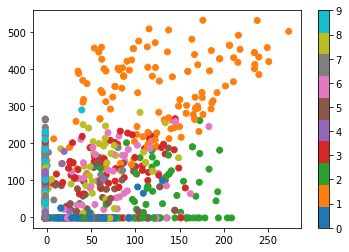

In [134]:
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

In [135]:
digit_size = 28
n = 25
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [136]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

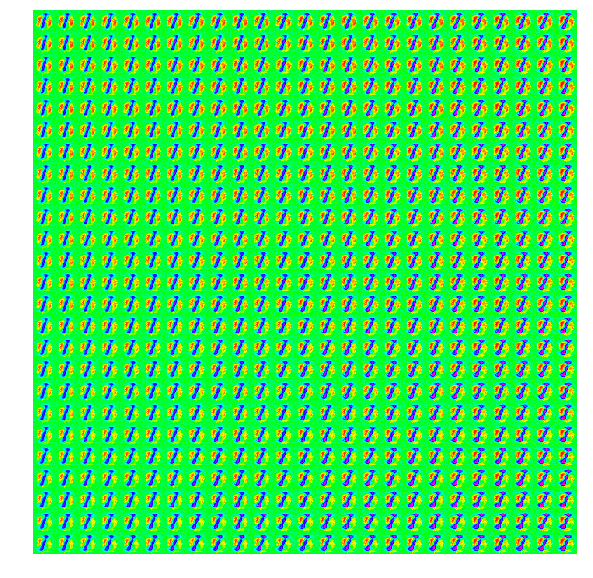

In [206]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='hsv')
plt.axis('off')
plt.show()

## 建立VAE 

In [138]:
enc_1 = Dense(128, activation='selu')
# enc_2 = Dense(2, activation='selu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(128, activation='selu')
dec_1 = Dense(784, activation='selu')

In [139]:
enc_x = enc_1(x)
h_input = Input(shape=(2,))
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [140]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [141]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [142]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [143]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 128)          100480      input_4[0][0]                    
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 2)            258         dense_37[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 2)            258         dense_37[0][0]                   
__________________________________________________________________________________________________
lambda_5 (

In [144]:
def vae_loss(x, x_recon):  
    recovery_loss = 128 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [146]:
VAE.compile(loss=vae_loss, optimizer='adam',metrics=['accuracy'])

In [147]:
VAE.fit(x_train, x_train, batch_size=128, epochs=30)

Epoch 1/30
60000/60000 [==============================] - 4s 66us/step - loss: 47.2412 - acc: 0.0026
Epoch 2/30
60000/60000 [==============================] - 3s 58us/step - loss: 39.3723 - acc: 0.0052
Epoch 3/30
60000/60000 [==============================] - 3s 58us/step - loss: 38.5797 - acc: 0.0112
Epoch 4/30
60000/60000 [==============================] - 4s 60us/step - loss: 35.3114 - acc: 0.0134
Epoch 5/30
60000/60000 [==============================] - 3s 57us/step - loss: 35.7332 - acc: 0.0137
Epoch 6/30
60000/60000 [==============================] - 3s 55us/step - loss: 36.4971 - acc: 0.0134
Epoch 7/30
60000/60000 [==============================] - 3s 56us/step - loss: 36.2427 - acc: 0.0108
Epoch 8/30
60000/60000 [==============================] - 3s 56us/step - loss: 35.6469 - acc: 0.0103
Epoch 9/30
60000/60000 [==============================] - 3s 56us/step - loss: 34.8896 - acc: 0.0135
Epoch 10/30
60000/60000 [==============================] - 3s 56us/step - loss: 35.0013 - a

In [148]:
VAE.save_weights('VAE_model_weights.h5')
VAE.load_weights('VAE_model_weights.h5')

In [149]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 258       
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________


In [150]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_41 (Dense)             (None, 784)               101136    
Total params: 101,520
Trainable params: 101,520
Non-trainable params: 0
_________________________________________________________________


In [151]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 22102 圖的 latent 表示為 [[-0.57807803  0.18188782]]


In [152]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

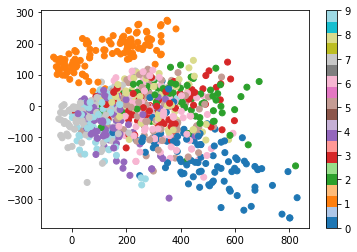

In [153]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [154]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [155]:

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

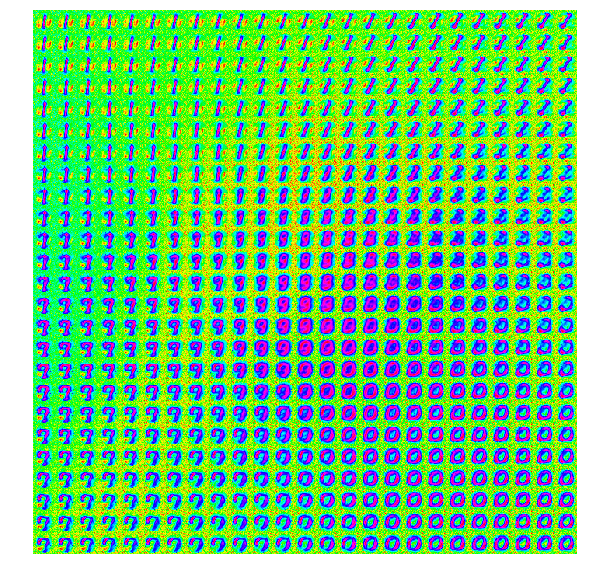

In [205]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='hsv')
plt.axis('off')
plt.show()

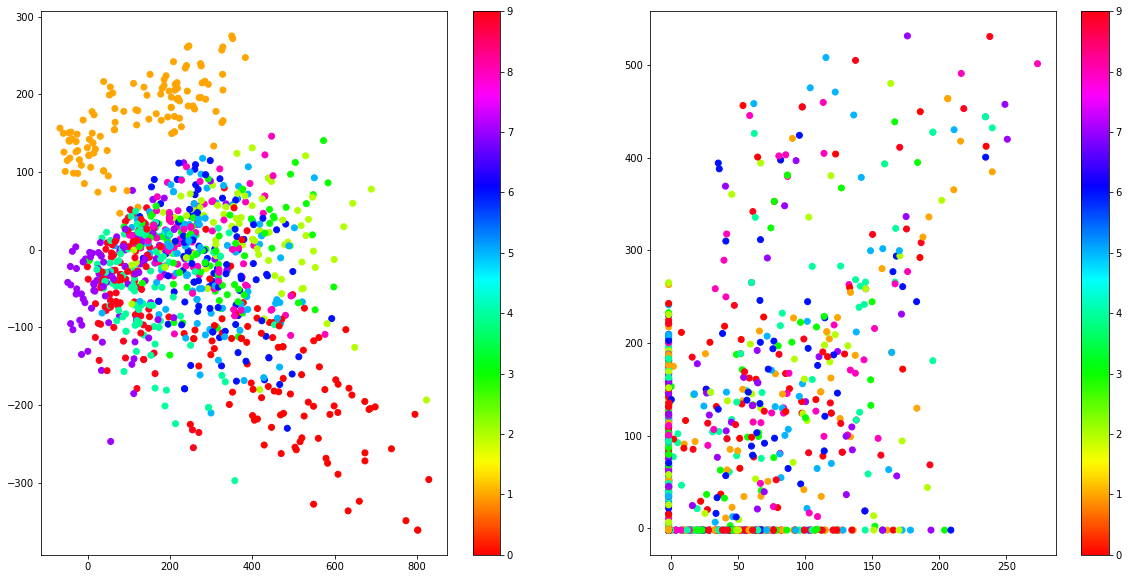

In [204]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='hsv')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='hsv')
plt.colorbar()
plt.show()

In [199]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    #加上一條線
    slope = (mu_1[1] - mu_0[1])/(mu_1[0] - mu_0[0])
    x_step = np.linspace(mu_0[0],mu_0[1],100)
    b = mu_1[1]-slope*mu_1[0]
    line = slope*x_step+b
    
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.plot(x_step,line,'k')
    
    ax1.scatter(mu_0[0], mu_0[1],color = 'r',label = 'Start')
    ax1.scatter(mu_1[0], mu_1[1],color = 'g',label = 'End')
    ax1.scatter(mu_t[0], mu_t[1],color = 'b',label = 'Trend')

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='magma')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='summer')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='bone')

In [200]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [201]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>